# Importing some packages

In [6]:
import pandas as pd
import numpy as np
import re
import string 
from math import radians, sin, cos, acos
import pickle
import os
from pathlib import Path

# Loading the data

In [7]:
df = pd.read_csv('data/estate.csv')
df.head()

,description,address,usd_price,amd_price,rub_price,seller_type,attributes,total_description,places_nearby,posted_date,renewed_date,seller_id,estate_type,estate_id
0,"2 room apartment, Pushkin Street, 48 sq.m., 3/...","Pushkin Street, Yerevan",165000,64779000,15386936,00591Agency,"[('Construction Type', 'Panels'), ('New Constr...",A 2-room apartment with an area of 48 square m...,Opera Theatre; Republic Square; Cascade; Verni...,2024-02-03,2024-04-19 00:00:00,capitalcity,apartment,/en/item/20602332
1,"3 room apartment on Yervand Kochar street, 90 ...","Yervand Kochar street, Yerevan",170000,66742000,15853207,307992Agency,"[('Construction Type', 'Panels'), ('New Constr...",For sale: 3-room E. On Kochar street. The apar...,Saint Gregory the Illuminator Cathedral; Verni...,2023-02-13,2024-04-18 00:00:00,658934,apartment,/en/item/19008391
2,"2 room apartment on Shahumyan 1st street, 62 s...","Shahumyan 1st street 4, Yerevan",88000,34548800,8206366,NaN,"[('Construction Type', 'Stone'), ('New Constru...",An apartment in Araratra 1 block is for sale w...,Unknown,2023-09-27,2024-04-20 00:00:00,21606,apartment,/en/item/20049462
3,"3 room apartment on Moldovakan street, 68 sq.m...","Մոլդովական փողոց 48/3, Yerevan",130000,51038000,12123040,NaN,"[('Construction Type', 'Panels'), ('New Constr...","In the 2nd block of Nor Nork, a 3-room apartme...",Unknown,2023-09-27,2024-04-20 00:00:00,1375140,apartment,/en/item/20050503
4,"3 room apartment, Vardanants Street, 68 sq.m.,...","Vardanants Street, Yerevan",165000,64779000,15386936,3k48Agency,"[('Construction Type', 'Panels'), ('New Constr...",(code 3k48) 3-room apartment for sale in the c...,Saint Gregory the Illuminator Cathedral; Verni...,2023-10-20,2024-04-18 00:00:00,2572754,apartment,/en/item/20153128


# EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23583 entries, 0 to 23582
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        23583 non-null  object
 1   address            23583 non-null  object
 2   usd_price          23583 non-null  object
 3   amd_price          23583 non-null  object
 4   rub_price          23583 non-null  object
 5   seller_type        20242 non-null  object
 6   attributes         23583 non-null  object
 7   total_description  23583 non-null  object
 8   places_nearby      23583 non-null  object
 9   posted_date        23583 non-null  object
 10  renewed_date       23583 non-null  object
 11  seller_id          23583 non-null  object
 12  estate_type        23583 non-null  object
 13  estate_id          23583 non-null  object
dtypes: object(14)
memory usage: 2.5+ MB


### Removing rows for which the price is not available

In [9]:
df = df[df['usd_price']!='Unknown'].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        22424 non-null  object
 1   address            22424 non-null  object
 2   usd_price          22424 non-null  object
 3   amd_price          22424 non-null  object
 4   rub_price          22424 non-null  object
 5   seller_type        19083 non-null  object
 6   attributes         22424 non-null  object
 7   total_description  22424 non-null  object
 8   places_nearby      22424 non-null  object
 9   posted_date        22424 non-null  object
 10  renewed_date       22424 non-null  object
 11  seller_id          22424 non-null  object
 12  estate_type        22424 non-null  object
 13  estate_id          22424 non-null  object
dtypes: object(14)
memory usage: 2.4+ MB


### Setting the dates to right format

Checking how many ads have not been updated

In [10]:
df[df['renewed_date']=='Unknown'].shape

(630, 14)

In [11]:
def create_dates(x):
    try:
        return pd.to_datetime(x)
    except:
        return 'not renewed'

df['posted_date'] = pd.to_datetime(df['posted_date'])
df['renewed_date'] = df['renewed_date'].apply(create_dates)

### Splitting attributes column to features

In [12]:
possible_attributes_list = list(
    set(
        [
            j.replace('[(', '').replace(')]', '').replace('(', '').\
            replace("'", '').split(',')[0].strip()
            for i in range(df.shape[0]) 
            for j in df.iloc[i]['attributes'].split('),')
        ]
    )
)

def split_attributes(x):
    attrs_tuple_list = x.split('),')
    attrs_tuple_list = [
        i.replace('[(', '').replace(')]', '').replace('(', '').\
        replace("'", '').split(',') 
        for i in attrs_tuple_list
    ]
    attrs_dict = {i[0].strip(): ', '.join([j.strip() for j in i[1:]]) for i in attrs_tuple_list}
    return attrs_dict


for possible_attribute in possible_attributes_list:
    df[possible_attribute] = df['attributes'].apply(
        lambda x: split_attributes(x)[possible_attribute] 
        if possible_attribute in split_attributes(x) 
        else 'Unknown'
    )
    print(f"{possible_attribute} values: {list(df[possible_attribute].unique())}")

df.drop(columns='attributes', inplace=True)


Number of Bathrooms values: ['1', '2', '3+']
Floor values: ['3', '14', '4', '1', '13', '2', '7', '5', '11', '8', '10', '9', '15', '6', '12', '16', '21', '20', '17', '19', '18', '22', '24', '25', '23', '32+']
Furniture values: ['Available', 'By agreement', 'Partial Furniture', 'Not available', 'Unknown']
Window Views values: ['Yard view', 'Unknown', 'Yard view, street view, city view, view of Ararat', 'Yard view, street view', 'Yard view, street view, city view', 'Yard view, street view, city view, park view, view of Ararat', 'City view, park view', 'Yard view, city view, view of Ararat', 'Street view, city view', 'Yard view, street view, park view', 'Yard view, park view', 'Yard view, city view, park view, view of Ararat', 'Yard view, street view, city view, park view', 'Yard view, city view, park view', 'Street view, city view, park view, view of Ararat', 'City view', 'City view, view of Ararat', 'Yard view, park view, view of Ararat', 'Yard view, city view', 'Street view', 'Yard view

#### Parking splitting

In [13]:
possible_parking_list = list(set(', '.join([i.lower().strip() for i in df['Parking'].unique()]).split(',')))
possible_parking_list = list(set([i.strip() for i in possible_parking_list if i.strip()!='unknown']))

def get_window_view_list(x):
    if len(x.split(',')) > 1:
        return [i.lower().strip() for i in x.split(',')]
    else:
        return [x.lower().strip()]

for possible_parking in possible_parking_list:
    df[possible_parking] = df['Parking'].apply(lambda x: 1 if possible_parking in get_window_view_list(x) else 0)
    print(f"{possible_parking} values: {list(df[possible_parking].unique())}")

df.drop(columns='Parking', inplace=True)

covered parking values: [0, 1]
garage values: [0, 1]
outdoor parking values: [1, 0]


#### Appliances splitting

In [14]:
possible_appliances_list = list(set(', '.join([i.lower().strip() for i in df['Appliances'].unique()]).split(',')))
possible_appliances_list = list(set([i.strip() for i in possible_appliances_list if i.strip()!='unknown']))

def get_window_view_list(x):
    if len(x.split(',')) > 1:
        return [i.lower().strip() for i in x.split(',')]
    else:
        return [x.lower().strip()]

for possible_appliance in possible_appliances_list:
    df[possible_appliance] = df['Appliances'].apply(lambda x: 1 if possible_appliance in get_window_view_list(x) else 0)
    print(f"{possible_appliance} values: {list(df[possible_appliance].unique())}")

df.drop(columns='Appliances', inplace=True)

stove values: [1, 0]
dishwasher values: [0, 1]
fridge values: [1, 0]
drying machine values: [0, 1]
washing machine values: [1, 0]
air conditioner values: [1, 0]


#### creating a new category for Elevator feature

In [15]:
df['Elevator'] = df['Elevator'].apply(lambda x: 'absent' if x.lower() in ['unknown', 'not available'] else x.lower())

#### creating a new category for Furniture feature

In [16]:
df['Furniture'] = df['Furniture'].apply(lambda x: 'absent' if x.lower() in ['unknown', 'not available', 'by agreement'] else x.lower())

#### Window Views splitting

In [17]:
possible_window_view_list = list(set(', '.join([i.lower().strip() for i in df['Window Views'].unique()]).split(',')))
possible_window_view_list = list(set([i.strip().replace('ararat', 'Ararat') for i in possible_window_view_list if i.strip()!='unknown']))

def get_window_view_list(x):
    if len(x.split(',')) > 1:
        return [i.lower().strip().replace('ararat', 'Ararat') for i in x.split(',')]
    else:
        return [x.lower().strip().replace('ararat', 'Ararat')]

for possible_window_view in possible_window_view_list:
    df[possible_window_view] = df['Window Views'].apply(lambda x: 1 if possible_window_view in get_window_view_list(x) else 0)
    print(f"{possible_window_view} values: {list(df[possible_window_view].unique())}")

df.drop(columns='Window Views', inplace=True)

street view values: [0, 1]
park view values: [0, 1]
view of Ararat values: [0, 1]
city view values: [0, 1]
yard view values: [1, 0]


#### creating new category for Renovation feature

In [18]:
df['Renovation'] = df['Renovation'].apply(lambda x: 'absent' if x.lower() in ['unknown', 'no renovation'] else x.lower())

#### Floor Area extraction

In [19]:
def get_sqm(x):
    try:
        return int(re.findall(r'\d?\d?\d?\.?\d?\d?', x)[0])
    except:
        return 999
    
df['Floor Area'] = df['Floor Area'].apply(get_sqm)

#### Floors in the Building extraction

In [20]:
def get_building_floors_num(x):
    try:
        return int(re.findall(r'\d?\d?', x)[0])
    except:
        return 999
    
df['Floors in the Building'] = df['Floors in the Building'].apply(get_building_floors_num)

#### creating a new category in Balcony feature

In [21]:
df['Balcony'] = df['Balcony'].apply(lambda x: 'absent' if x.lower() in ['unknown', 'not available'] else x.lower())

#### Ceiling height extraction

In [22]:
def get_ceiling_height(x):
    try:
        return float(re.findall(r'\d.?\d?\d?', x)[0])
    except:
        return 999
    
df['Ceiling Height'] = df['Ceiling Height'].apply(get_ceiling_height)

#### Floor extraction

In [23]:
def get_floor_num(x):
    try:
        return int(re.findall(r'\d?\d?', x)[0])
    except:
        return 999
    
df['Floor'] = df['Floor'].apply(get_floor_num)

#### "The House Has" column splitting

In [24]:
possible_has_list = list(set(', '.join([i.lower() for i in df['The House Has'].unique()]).split(',')))
possible_has_list = list(set([i.strip() for i in possible_has_list if i.strip()!='unknown']))

def get_has_list(x):
    if len(x.split(',')) > 1:
        return [i.lower().strip() for i in x.split(',')]
    else:
        return [x.lower().strip()]

for possible_has in possible_has_list:
    df[possible_has] = df['The House Has'].apply(lambda x: 1 if possible_has in get_has_list(x) else 0)
    print(f"{possible_has} values: {list(df[possible_has].unique())}")

df.drop(columns='The House Has', inplace=True)

concierge values: [0, 1]
intercom entry values: [0, 1]
playground values: [0, 1]


### Getting square meter prices

In [25]:
# removing rows where floor area is missing
df = df[df['Floor Area']!=999].reset_index(drop=True)

df['usd_price'] = df['usd_price'].apply(float)

df['sqm_price_usd'] =  df['usd_price'] / df['Floor Area']
# df['sqm_price_amd'] = df['amd_price'] / df['Floor Area']
# df['sqm_price_rub'] = df['rub_price'] / df['Floor Area']

df.drop(columns=['usd_price', 'amd_price', 'rub_price'], inplace=True)

### "Tuning" seller_type feature

In [26]:
df['seller_type'].fillna('individual', inplace=True)
df['seller_type'] = df['seller_type'].apply(lambda x: 'agency' if 'Agency' in x else 'individual')

C:\Users\vchar\AppData\Local\Temp\ipykernel_19108\2794963514.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['seller_type'].fillna('individual', inplace=True)


### Dealing with the estate_id

In [27]:
df['estate_id'] = df['estate_id'].apply(lambda x: int(x.replace('/en/item/', '')))

### Showing possible places_nearby and removing the feature

In [28]:
places_by_list = list(
    set(
        [
            j.strip() for i in range(df.shape[0]) 
            for j in df.iloc[i]['places_nearby'].split(';') 
            if j!='Unknown'
        ]
    )
)
places_by_list

['Russian-Armenian University',
 'Kievyan Bridge',
 'Gortsaranayin Metro Station',
 'Cascade',
 'Vernissage',
 'Opera Theatre',
 'Shengavit Metro Station',
 'Reebok Sports Club',
 'Republic Square',
 'Vartanants Square',
 'Barekamutyun Metro Station',
 'Lovers Park',
 'Marshal Baghramyan Metro Station',
 'Saint Gregory the Illuminator Cathedral',
 'Dalma Garden Mall',
 'Yerevan State Medical University',
 'Yerevan Railway Station',
 'Victory Park',
 'Orange Fitness Premium Club',
 'Matenadaran',
 'Yerevan Mall',
 'Garegin Nzhdeh Square',
 'Yeritasardakan Metro Station',
 'General Andranik Metro Station']

In [29]:
df.drop(columns='places_nearby', inplace=True)

### Dealing with address feature

In [30]:
# df[df['address'].apply(lambda x: True if 'Yerevan Highway' in x else False)]

In [31]:
region_map_dict = {
    'Երևան': 'Yerevan', 'Հրազդան': 'Hrazdan', 'Վանաձոր': 'Vanadzor',
    'Ереван': 'Yerevan', 'Աբովյան': 'Abovyan', 'Առինջ': 'Arinj',
    'Արտաշատ': 'Artashat', 'Ծաղկաձոր': 'Tsaghkadzor', 'Արարատ': 'Ararat',
    'Չարենցավան': 'Charentsavan', 'Մասիս': 'Masis', 'Քասախ': 'Qasakh',
    'Lorri': 'Lori', 'Гюмри': 'Gyumri', 'Սևան': 'Sevan', 'Ванадзор': 'Vanadzor',
    'Ախուրյան': 'Akhuryan', 'Էջմիածին քաղաք': 'Vagharshapat', 'Մարտունի': 'Martuni', 
    'Նոր Գեղի': 'Nor Geghi', 'Մերձավան': 'Merdzavan', 'Раздан': 'Hrazdan',
    'Ավան': 'Avan', 'Мецамор': 'Metsamor', 'Դիլիջան': 'Dilijan', 'Ջերմուկ': 'Jermuk',
    'Եղվարդ': 'Yeghvard', 'Նոր Հաճըն': 'Nor Hachin', 'Абовян': 'Abovyan', 
    'Արմավիր': 'Armavir', 'Բյուրեղավան': 'Byureghavan', 'Зовуни': 'Zovuni', 
    'Գյումրի': 'Gyumri', 'Вагаршапат': 'Vagharshapat', 'Դաշտավան': 'Dashtavan', 
    'Էջմիածին': 'Vagharshapat', 'Ташир': 'Tashir', 'Ехвард': 'Yeghvard', 'Փշատավան': 'Pshatavan', 
    'Աշտարակ': 'Ashtarak', 'Ejmiatsin': 'Vagharshapat', 'Վեդի': 'Vedi', 
    'Վարդենիս': 'Vardenis', 'Փարաքար': 'Parakar', 'Սիսիան': 'Sisian', 'Գավառ': 'Gavar',
    'Շահումյան': 'Shahumyan', 'Վաղարշապատ': 'Vagharshapat', 'Քաջարան': 'Qajaran',
    'Իջևան': 'Ijevan', 'Ջրվեժ': 'Jrvej', 'Կապան': 'Kapan', 'Ապարան': 'Aparan', 
    'Արթիկ': 'Artik', 'Թաիրով': 'Tairov', 'Арташат': 'Artashat', 'Մոնթեավան': 'Monteavan', 
    'Գորիս': 'Goris', 'Ավշար': 'Avshar', 'Զովունի': 'Zovuni', 'Масис': 'Masis'
}

In [32]:
def split_address(x):
    if '›' in x:
        split_result = [
            region_map_dict[i.strip()] if i.strip() in region_map_dict 
            else i.strip() for i in x.split('›')
        ]
        return split_result
    else:
        comma_split = [
            region_map_dict[i.strip()] if i.strip() in region_map_dict
            else i.strip() for i in x.split(',')
        ]
        if len(comma_split) == 1:
            return x
        else:
            if len(comma_split[0]) > len(comma_split[1]):
                return comma_split[::-1]
            else:
                if 'street' in comma_split[0].lower() or 'փողոց' in comma_split[0]:
                    return comma_split[::-1]
                else:
                    return comma_split

df['address'].apply(lambda x: split_address(x)[0]).unique()

array(['Yerevan', 'Shirak', 'Hrazdan', 'Zovuni', 'Vanadzor', 'Kotayk',
       'Abovyan', 'Arinj', 'Gyumri', 'Artashat', 'Tsaghkadzor',
       'ՔՇՀ-4 22', 'Ararat', 'U', '3-րդ թաղամաս', 'Masis', 'Vagharshapat',
       'Armavir', 'Qasakh', 'Lori', 'Sevan', 'Aragatsotn', 'Akhuryan',
       'Yerevan Highway', 'Tavush', 'Martuni', 'Nor Geghi', 'Merdzavan',
       'Artaxata (Artashat)', 'Avan', 'Metsamor', 'Dilijan', 'Jermuk',
       'Yeghvard', 'Nor Hachin', 'Spitak', 'Charentsavan', 'Byureghavan',
       'Dashtavan', 'Tashir', 'Garni', 'Ashtarak', 'Pshatavan', 'Syunik',
       'Sevan town', 'Vedi', 'Mrgashen village', 'Vayots Dzor',
       'Vardenis', 'Parakar', 'Sisian', 'Gavar', 'Shahumyan', 'Qajaran',
       'Vayk', 'Ijevan', '26 St', 'Jrvej', 'Նոր Նորքի 9-րդ զանգված',
       'Kapan', 'Aparan', 'Artik', 'Gegharkunik', 'Tairov', 'Monteavan',
       'Goris', 'Avshar', 'Argavand', '8-й район', 'Մարմարաշեն',
       'Նոր Հաճն', 'Մեծամոր', 'Ազատավան', 'Араксаван', 'Օգոստոսի',
       'Shiraz',

Checking for distribution among regions/cities

In [33]:
temp_map = (df['address'].apply(lambda x: split_address(x)[0]).value_counts() > 10)
df['address'].apply(lambda x: split_address(x)[0]).value_counts()[temp_map]

address
Yerevan                   21029
Vanadzor                    132
Kotayk                      132
Abovyan                     124
Gyumri                      121
Armavir                      88
Hrazdan                      66
Vagharshapat                 65
Tsaghkadzor                  55
Ararat                       34
Shirak                       33
Masis                        31
Lori                         29
Sevan                        25
U                            24
Dilijan                      23
Charentsavan                 23
Artashat                     22
Ashtarak                     19
Gegharkunik                  18
Jermuk                       16
Zovuni                       14
Նոր Նորքի 9-րդ զանգված       13
Aragatsotn                   13
Syunik                       12
Vayots Dzor                  12
Name: count, dtype: int64

Creating region column

In [34]:
df['region'] = df['address'].apply(lambda x: split_address(x)[0])

In [37]:
df['region'].value_counts()[df['region'].value_counts()<=10]

region
Qasakh                  10
Arinj                   10
Byureghavan             10
Metsamor                10
Ijevan                   9
                        ..
1 St 6                   1
4 թաղամաս 25             1
Եղեգնաձոր                1
Nor Nork 9th massive     1
Ариндж                   1
Name: count, Length: 112, dtype: int64

In [43]:
df['region'].value_counts()[df['region'].value_counts()==1]

region
Чаренцаван              1
Getargel village        1
Ճամբարակ                1
Օձուն                   1
Gai ave                 1
                       ..
1 St 6                  1
4 թաղամաս 25            1
Եղեգնաձոր               1
Nor Nork 9th massive    1
Ариндж                  1
Name: count, Length: 73, dtype: int64

In [40]:
# df[df['region']=='U']

In [41]:
df = df[df['region']!='U'].reset_index(drop=True)

# town2region_dict = {
#     'Hrazdan': 'Kotayk',
# }

In [38]:
df['region'].unique()

array(['Yerevan', 'Shirak', 'Hrazdan', 'Zovuni', 'Vanadzor', 'Kotayk',
       'Abovyan', 'Arinj', 'Gyumri', 'Artashat', 'Tsaghkadzor',
       'ՔՇՀ-4 22', 'Ararat', 'U', '3-րդ թաղամաս', 'Masis', 'Vagharshapat',
       'Armavir', 'Qasakh', 'Lori', 'Sevan', 'Aragatsotn', 'Akhuryan',
       'Yerevan Highway', 'Tavush', 'Martuni', 'Nor Geghi', 'Merdzavan',
       'Artaxata (Artashat)', 'Avan', 'Metsamor', 'Dilijan', 'Jermuk',
       'Yeghvard', 'Nor Hachin', 'Spitak', 'Charentsavan', 'Byureghavan',
       'Dashtavan', 'Tashir', 'Garni', 'Ashtarak', 'Pshatavan', 'Syunik',
       'Sevan town', 'Vedi', 'Mrgashen village', 'Vayots Dzor',
       'Vardenis', 'Parakar', 'Sisian', 'Gavar', 'Shahumyan', 'Qajaran',
       'Vayk', 'Ijevan', '26 St', 'Jrvej', 'Նոր Նորքի 9-րդ զանգված',
       'Kapan', 'Aparan', 'Artik', 'Gegharkunik', 'Tairov', 'Monteavan',
       'Goris', 'Avshar', 'Argavand', '8-й район', 'Մարմարաշեն',
       'Նոր Հաճն', 'Մեծամոր', 'Ազատավան', 'Араксаван', 'Օգոստոսի',
       'Shiraz',

Creating binary features to indicate whether an apartment is Yerevan or not

In [44]:
def apply_Yerevan(x):
    if 'Երևան' in x or 'Ереван' in x:
        return x.replace('Երևան', 'Yerevan').replace('Ереван', 'Yerevan')
    else:
        return x

# df['address'] = df['address'].apply(apply_Yerevan)
df['is_capital'] = df['address'].apply(apply_Yerevan).apply(lambda x: 1 if 'Yerevan' in x else 0)

Checking for street names

In [143]:
df['address'].apply(lambda x: split_address(x)[1]).unique()

array(['Pushkin Street', 'Yervand Kochar street',
       'Shahumyan 1st street 4', ..., 'Квартал Кентрон 47',
       'Улица Нвера Сафаряна', 'Հայկ Գյուլիքևխյանի փողոց'], dtype=object)

Creating Yerevan districts' street names

In [144]:
ajapnyak_text = '''Հալաբյան փողոց
Գրիգոր Հասրաթյան փողոց
Շիրազի փողոց
Աշտարակի խճուղի
Չաուշի փողոց
Սիլիկյան նոր խճուղի
Սեբաստիա փողոց
Լենինգրադյան փողոց
Բեկնազարյան փողոց
Բաշինջաղյան փողոց
Մազմանյան փողոց
Շինարարների փողոց
Մարգարյան փողոց
Աբելյան փողոց'''

avan_text = '''Բաբաջանյան փողոց
Աճառյան փողոց
Ռուբինյանց փողոց
Խուդյակովի փողոց
Բագրևանդի փողոց'''

arabkir_text = '''Բաղրամյան պողոտա
Կասյան փողոց
Քոչարի փողոց
Վաղարշյան փողոց
Սարալանջի փողոց
Կոմիտասի պողոտա
Կիևյան փողոց
Ազատության պողոտա
Թբիլիսյան խճուղի
Օրբելի եղբայրների փողոց
Ավետիսյան փողոց
Համբարձումյան փողոց
Հակոբյան փողոց
Խաչատրյան փողոց
Գյուլբենկյան փողոց
Փափազյան փողոց
Մամիկոնյանց փողոց
Տիգրանյան փողոց
Շահսուվարյան փողոց
Վրացական փողոց
Բաբայան փողոց
Գրիբոյեդովի փողոց
Շիրվանզադեի փողոց
Զարյան փողոց
Ադոնցի փողոց'''

davtashen_text = '''Միկոյան փողոց 
Սասնա Ծռերի փողոց
Պետրոսյան փողոց
Փիրումյան փողոց
Աղաբաբյան փողոց
Գևորգյան փողոց'''

erebuni_text = '''Տիգրան Մեծի պողոտա
Արցախի պողոտա
Այվազովսկու փողոց
Էրեբունու փողոց
Դավիթ Բեկի փողոց
Ռոստովյան փողոց
Գարեգին Նժդեհի փողոց
Խորենացու փողոց
Բելինսկու փողոց
Ազատամարտիկների պողոտա
Արին-Բերդի փողոց
Դաշտենցի փողոց
Նուբարաշենի խճուղի
Սասունցի Դավթի փողոց
Խաղաղ Դոնի փողոց
Տիտոգրադյան փողոց
Աթոյան փողոց'''

kentron = '''Բաղրամյան պողոտա
Մաշտոցի պողոտա
Կորյունի փողոց
Սարյան փողոց
Ամիրյան փողոց
Տիգրան Մեծի պողոտա
Խանջյան փողոց
Աբովյան փողոց
Նալբանդյան փողոց
Մոսկովյան փողոց
Հերացու փողոց
Մյասնիկյան պողոտա
Խորենացու փողոց
Պռոշյան փողոց
Ագաթանգեղոսի փողոց
Արշակունյաց պողոտա
Իսակովի պողոտա
Չարենցի փողոց
Նար-Դոսի փողոց
Սայաթ-Նովայի պողոտա
Ծիծեռնակաբերդի խճուղի
Գետառի փողոց
Պարոնյան փողոց
Սարալանջի փողոց
Աթենքի փողոց
Գրիգոր Լուսավորչի փողոց
Վարդանանց փողոց
Իսրայելյան փողոց
Ձորափի փողոց
Արամի փողոց
Բուզանդի փողոց
Պուշկինի փողոց
Ֆիրդուսի փողոց
Զորյանի փողոց
Կողբացու փողոց
Տպագրիչների փողոց
Անտառային փողոց
Քաջազնունու փողոց
Տերյան փողոց
Հանրապետության փողոց
Մկրտչյան փողոց 
Մելիք-Ադամյան փողոց
Զաքյան փողոց
Լեոյի փողոց
Քոչարի փողոց
Մանուկյան փողոց
Դեմիրճյան փողոց
Արգիշտիի փողոց
Շարիմանյան փողոց
Բեյրութի փողոց
Իտալիայի փողոց
Սարգսյան փողոց'''

malatia_sebastia_text = '''Սեբաստիայի փողոց
Ծովակալ Իսակովի պողոտա
Բաբաջանյան փողոց
Րաֆֆու փողոց
Շերամի փողոց
Ամերիկյան փողոց
Տիչինայի փողոց
Օհանովի փողոց
Զորավար Անդրանիկի փողոց
Լենինգրադյան փողոց
Շիրակի փողոց 
Մալաթիայի փողոց 
Արարատյան փողոց'''

nor_norq_text = '''Գայի պողոտա
Մյասնիկյանի պողոտա
Թևոսյան փողոց
Բագրևանդի փողոց
Բ.Մուրադյան փողոց
Քոչինյան փողոց
Դավիթ Բեկի փողոց
Միկոյան փողոց
Գյուլիքևխյան փողոց 
Գյուրջյան փողոց
Գալշոյան փողոց
Շոպրոնի փողոց
Սաֆարյան փողոց'''

norq_marash_text = '''Արմենակյան փողոց
Հովսեփյան փողոց'''

nubarashen_text = '''Նուբարաշենի խճուղի'''

shengavit_text = '''Շիրակի փողոց
Արտաշեսյան պողոտա
Արտաշատի խճուղի
Արշակունյաց պողոտա
Գագեգին Նժդեհի փողոց
Բագրատունյաց փողոց
Թամանցիների փողոց
Եղբայրության փողոց 
Մանանդյան փողոց
Մանթաշյան փողոց
Մայիսի 9-ի փողոց
Ֆրունզեի փողոց 
Չեխովի փողոց
Արարատյան փողոց 
Նորագավիթի 1-ին փողոց'''

qanaqer_zeytun_text = '''Դավիթ Անհաղթի փողոց
Ռուբինյանց փողոց
Սևակի փողոց
Զաքարիա Քանաքեռցու փողոց
Հասրաթյան փողոց
Ուլնեցու փողոց
Քանաքեռ 1-ին փողոց'''#/Սարկավագի/

Creating Russian to English letters converter dictionary

In [145]:
temp_text = '''⟨б⟩, ⟨в⟩, ⟨г⟩, ⟨д⟩, ⟨ж⟩, ⟨з⟩, ⟨к⟩, ⟨л⟩, ⟨м⟩, ⟨н⟩, 
⟨п⟩, ⟨р⟩, ⟨с⟩, ⟨т⟩, ⟨ф⟩, ⟨х⟩, ⟨ц⟩, ⟨ч⟩, ⟨ш⟩, ⟨щ⟩, ⟨а⟩, ⟨е⟩, ⟨ё⟩, 
⟨и⟩, ⟨о⟩, ⟨у⟩, ⟨ы⟩, ⟨э⟩, ⟨ю⟩, ⟨я⟩, ⟨й⟩, ⟨ъ⟩, ⟨ь⟩'''

temp_text = temp_text.replace('⟨', '').replace('⟩', '').replace('\n', '').split(',')
temp_text = [i.strip() for i in temp_text]

rus2eng_letters_list = [
    'b', 'v', 'g', 'd', 'jհ', 'z', 'k', 'l', 'm', 'n', 'p', 
    'r', 's', 't', 'f', 'kh', 'ts', 'ch', 'sh', 'sh', 'a', 'e', 
    'e', 'i', 'o', 'u', 'i', 'e', 'yu', 'ya', 'i', '', ''
]

rus2eng_letters_dict = {temp_text[i]: rus2eng_letters_list[i] for i in range(len(temp_text))}
# rus2eng_letters_dict.update({' ':' '})
print(rus2eng_letters_dict)

{'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'ж': 'jհ', 'з': 'z', 'к': 'k', 'л': 'l', 'м': 'm', 'н': 'n', 'п': 'p', 'р': 'r', 'с': 's', 'т': 't', 'ф': 'f', 'х': 'kh', 'ц': 'ts', 'ч': 'ch', 'ш': 'sh', 'щ': 'sh', 'а': 'a', 'е': 'e', 'ё': 'e', 'и': 'i', 'о': 'o', 'у': 'u', 'ы': 'i', 'э': 'e', 'ю': 'yu', 'я': 'ya', 'й': 'i', 'ъ': '', 'ь': ''}


Creating Armenian to English letter conversion dictionary

In [146]:
temp_text = '''ա a,	ճ ch, բ	b, մ m, գ g, յ y,
դ d, ն n, ե	e, շ sh, զ z, ո	o, է e,	չ ch,
ը e, պ p, թ t, ջ j, ժ jh, ռ	r, ի i, ս s,
լ l, վ v, խ	kh, տ t, ծ ts, ր r, կ k, ց ts,
հ h, ու u, ձ dz, փ p, ղ gh, ք q, և ev, օ o,	
ֆ f'''

temp_text = temp_text.replace('\n', '').replace('\t', ' ').split(',')
temp_text = [i.strip().split(' ') for i in temp_text]
len(temp_text)

arm2eng_letters_dict = {elem[0]: elem[1] for elem in temp_text}
# arm2eng_letters_dict.update({' ':' '})
print(arm2eng_letters_dict)

{'ա': 'a', 'ճ': 'ch', 'բ': 'b', 'մ': 'm', 'գ': 'g', 'յ': 'y', 'դ': 'd', 'ն': 'n', 'ե': 'e', 'շ': 'sh', 'զ': 'z', 'ո': 'o', 'է': 'e', 'չ': 'ch', 'ը': 'e', 'պ': 'p', 'թ': 't', 'ջ': 'j', 'ժ': 'jh', 'ռ': 'r', 'ի': 'i', 'ս': 's', 'լ': 'l', 'վ': 'v', 'խ': 'kh', 'տ': 't', 'ծ': 'ts', 'ր': 'r', 'կ': 'k', 'ց': 'ts', 'հ': 'h', 'ու': 'u', 'ձ': 'dz', 'փ': 'p', 'ղ': 'gh', 'ք': 'q', 'և': 'ev', 'օ': 'o', 'ֆ': 'f'}


Creating street-district dictionary

In [147]:
district_text_list = [
    ajapnyak_text, avan_text, arabkir_text, davtashen_text, erebuni_text, kentron, 
    malatia_sebastia_text, nor_norq_text, norq_marash_text, nubarashen_text, 
    shengavit_text, qanaqer_zeytun_text
]

district_names = [
    'ajapnyak', 'avan', 'arabkir', 'davtashen', 'erebuni', 'kentron', 
    'malatia_sebastia', 'nor_norq', 'norq_marash', 'nubarashen', 
    'shengavit', 'qanaqer_zeytun'
]

def convert_arm2eng_street(street):
    street = street.lower()
    street = list(street)
    for idx in range(len(street)):
        if idx == 0 and street[idx] == 'ո' and street[idx+1] != 'ւ':
            street[idx] = 'vo'
        # elif idx == 0 and street[idx] == 'е':
        #     street[idx] = 'ye'
        elif street[idx] == 'ւ':
            street[idx] = ''
        elif street[idx] not in arm2eng_letters_dict.keys(): #in [' ', '-', '.', '1', 's', 't', '9']
            pass
        elif idx < len(street) - 1:
            if street[idx] == 'ո' and street[idx+1] == 'ւ':
                street[idx] = arm2eng_letters_dict['ու']
            else:
                street[idx] = arm2eng_letters_dict[street[idx]]
        else:
            street[idx] = arm2eng_letters_dict[street[idx]]
    return ''.join(street)

street_district_dict = {}

for idx in range(len(district_text_list)):
    district_streets = district_text_list[idx].replace('\n', ',').split(',')
    district_streets = [
        i.replace('փողոց', '').replace('պողոտա', '').replace('խճուղի', '').\
        replace('1-ին', '1st') .replace('9-ի', '9').strip()
        for i in district_streets
    ]
            
    eng_streets = [convert_arm2eng_street(district_street) for district_street in district_streets]
    temp_street_district_dict = {street: district_names[idx] for street in eng_streets}
    street_district_dict.update(temp_street_district_dict)

# street_district_dict.pop('')
street_district_dict

{'halabyan': 'ajapnyak',
 'grigor hasratyan': 'ajapnyak',
 'shirazi': 'ajapnyak',
 'ashtaraki': 'ajapnyak',
 'chaushi': 'ajapnyak',
 'silikyan nor': 'ajapnyak',
 'sebastia': 'ajapnyak',
 'leningradyan': 'malatia_sebastia',
 'beknazaryan': 'ajapnyak',
 'bashinjaghyan': 'ajapnyak',
 'mazmanyan': 'ajapnyak',
 'shinararneri': 'ajapnyak',
 'margaryan': 'ajapnyak',
 'abelyan': 'ajapnyak',
 'babajanyan': 'malatia_sebastia',
 'acharyan': 'avan',
 'rubinyants': 'qanaqer_zeytun',
 'khudyakovi': 'avan',
 'bagrevandi': 'nor_norq',
 'baghramyan': 'kentron',
 'kasyan': 'arabkir',
 'qochari': 'kentron',
 'vagharshyan': 'arabkir',
 'saralanji': 'kentron',
 'komitasi': 'arabkir',
 'kievyan': 'arabkir',
 'azatutyan': 'arabkir',
 'tbilisyan': 'arabkir',
 'orbeli eghbayrneri': 'arabkir',
 'avetisyan': 'arabkir',
 'hambardzumyan': 'arabkir',
 'hakobyan': 'arabkir',
 'khachatryan': 'arabkir',
 'gyulbenkyan': 'arabkir',
 'papazyan': 'arabkir',
 'mamikonyants': 'arabkir',
 'tigranyan': 'arabkir',
 'shahsuvary

In [148]:
new_street2district_dict = {
    'zakhariya sarkavag': 'qanaqer_zeytun',
    'tumanyan': 'kentron',
    'shahumyan': 'malatia_sebastia',
    'totoventsi': 'nor_norq',
    'vilnyus': 'nor_norq',
    'sundukyan': 'kentron',
    'eghishe tadevosyan': 'shengavit',
    'artashisyan': 'shengavit',
    'duryan': 'avan',
    'zakaria sarkavag': 'qanaqer_zeytun',
    'sayat nova': 'kentron',
    'karakhanyan': 'nor_norq',
    'mikhail chailakhyan': 'kentron',
    'gogoli': 'qanaqer_zeytun',
    'nor aresh': 'erebuni',
    'moldovakan': 'nor_norq',
    'orbeli brothers': 'kentron',
    'khorenatsi': 'kentron',
    'movses khorenatsi': 'kentron',
    'dro': 'qanaqer_zeytun',
    'arno babajanian': 'malatia_sebastia',
    'gulakyan': 'kentron',
    'lepsius': 'qanaqer_zeytun',
    'tbilisian': 'qanaqer_zeytun',
    'tsarav aghbyuri': 'avan',
    'frik': 'kentron',
    'raffi': 'malatia_sebastia',
    'arghutyan': 'arabkir',
    'luxemburg': 'nor_norq',
    'kajaznuni': 'kentron',
    'sisakyan': 'ajapnyak',
    'bryusov': 'kentron', 
    'gai': 'nor_norq', 
    'sisvan': 'kentron', 
    'vardashen': 'erebuni', 
    'tamanyan': 'kentron',
    'melik melikyan': 'qanaqer_zeytun',
    'qeri': 'arabkir', 
    'zaqyan': 'kentron',
    'melkumov': 'davtashen', 
    'arghutyan': 'arabkir', 
    'avet': 'kentron',
    'avet avetisyan': 'kentron', 
    'arshakuniats': 'kentron',  
    'gyulikekhvyan': 'nor_norq',
    'rubiniants': 'qanaqer_zeytun', 
    'davit malyan': 'avan',
    'sharuri': 'shengavit', 
    'chaykovski': 'kentron', 
    'bakunts': 'nor_norq', 
    'erznkyan': 'kentron', 
    'zavaryan': 'kentron',
    'hunan': 'erebuni', 
    'lvovyan': 'nor_norq', 
    'kristapor': 'kentron',
    'aghbyur serob': 'kentron', 
    'margarian': 'ajapnyak', 
    'kurghinyan': 'malatia_sebastia', 
    'avanesov': 'erebuni', 
    'byuzand': 'kentron',
    'hyusisayin': 'kentron', 
    'ulnetsi': 'qanaqer_zeytun', 
    'khaghag don': 'erebuni', 
    'leo': 'kentron',
    'hovsep emin': 'arabkir', 
    'nansen': 'nor_norq', 
    'babadjհanyana': 'avan',
    'malkhasyants': 'arabkir', 
    'rostom': 'kentron', 
    'hrachya nersisyan': 'qanaqer_zeytun', 
    'koghbaci': 'kentron',
    'parpetsu': 'kentron', 
    'aharonyan': 'qanaqer_zeytun', 
    'mari': 'nor_norq',
    'shovroyan': 'qanaqer_zeytun', 
    'baghyan': 'nor_norq', 
    'minsk': 'nor_norq',
    'tolbukhin': 'qanaqer_zeytun', 
    'minas': 'qanaqer_zeytun', 
    'kokhbatsi': 'kentron', 
    'deghatan': 'kentron',
    'khanzadyan': 'nor_norq', 
    'meliq meliqyan': 'qanaqer_zeytun', 
    'sasnatsrer': 'arabkir',
    'aragats': 'shengavit', 
    'nizami': 'shengavit', 
    'avanesov': 'kentron', 
    'aghayan': 'kentron',
    'monte melkonyan': 'ajapnyak_text', 
    'yekmalyan': 'kentron', 
    'malatia': 'malatia_sebastia', 
    'isabekyan': 'nor_norq', 
    'isahakyan': 'kentron', 
    'quchak': 'malatia_sebastia'
}

street_district_dict.update(new_street2district_dict)

Keeping only Yerevan apartments

In [149]:
def apply_Yerevan(x):
    if 'Երևան' in x or 'Ереван' in x:
        return x.replace('Երևան', 'Yerevan').replace('Ереван', 'Yerevan')
    else:
        return x

df['address'] = df['address'].apply(apply_Yerevan)
df = df[df['address'].apply(lambda x: True if 'Yerevan' in x else False)].reset_index(drop=True)

In [150]:
# df['address'].apply(get_street)[df['address'].apply(lambda x: True if 'улица' in x.lower() else False)]

#### Getting district names

In [151]:
def get_street(x):
    x = x.replace('Երևան', '').replace('Yerevan', '').replace('Ереван', '').\
        replace(' Ave', 'Avenue').replace(' St', 'Street').replace('srteet', 'street')
    try:
        street_tuple = re.findall(
            r'улица(.*)|(.*)նրբ.|шоссе(.*)|(.*)блок|(.*)անցուղի|(.*)deadlock|(.*)ավտոմայրուղի|(.*)lane|(.*)квартал|(.*)զանգված|(.*)փակուղի|(.*)quarter|(.*)avenu|(.*)district|(.*)street|(.*)փողոց|(.*)highway|(.*)avenue|(.*)block|(.*)թաղամաս|(.*)վարչական շրջան|(.*)պողոտա|(.*)խճուղի|проспект(.*)|переулок(.*)|(.*)նրբանցք', 
            x.lower()
        )[0]
        street = ''.join(list(street_tuple)).strip()
        return street
    except: 
        if '›' in x:
            return ''.join(x.lower().split('›')).strip()
        elif 'Avan-Arinj' in x or 'Ավան-Առինջ' in x:
            return 'avan-arinj'
        else:
            return x

df['street_name'] = df['address'].apply(get_street)
df['street_name']

# convert_arm2eng_street
# arm2eng_letters_dict
# rus2eng_letters_dict
# street_district_dict


0                pushkin
1         yervand kochar
2          shahumyan 1st
3             մոլդովական
4             vardanants
              ...       
6673         tpagrichner
6674    yeznik koghbatsi
6675    zoravar andranik
6676       davtashen 4th
6677           margarian
Name: street_name, Length: 6678, dtype: object

In [152]:
def convert_rus2eng_street(street):
    street = street.lower()
    street = list(street)
    for idx in range(len(street)):
        if idx == 0 and street[idx] == 'е':
            street[idx] = 'ye'
        elif street[idx] in [' ', '-', '.', '1', 's', 't', '9']:
            pass
        else:
            if street[idx] in rus2eng_letters_dict.keys():
                street[idx] = rus2eng_letters_dict[street[idx]]
            else:
                pass
    return ''.join(street)

eng_letters = list(string.ascii_lowercase)

def detect_language(street):
    street = street.lower()
    street = list(street)
    language_list = [0, 0, 0]
    for letter in street:
        if letter in rus2eng_letters_dict.keys():
            language_list[0] += 1
        if letter in arm2eng_letters_dict.keys():
            language_list[1] += 1
        if letter in eng_letters:
            language_list[2] += 1

    if language_list.index(max(language_list)) == 0:
        return 'rus'
    elif language_list.index(max(language_list)) == 1:
        return 'arm'
    else:
        return 'eng'
    
def translate_street(street):
    language = detect_language(street)
    if language == 'arm':
        street = convert_arm2eng_street(street)
    elif language == 'rus':
        street = convert_rus2eng_street(street)
    else:
        pass
    return street
    
df['street_name'] = df['street_name'].apply(translate_street)

In [153]:
def get_district(x):
    for street in street_district_dict.keys():
        temp_street = list(street)
        if temp_street[-1] == 'i':
            temp_street[-1] = ''
        temp_street = ''.join(temp_street)
        if temp_street in x:
            return street_district_dict[street]
    if 'davtashen' in x or 'davidashen' in x:
        return 'davtashen'
    elif 'arabkir' in x:
        return 'arabkir'
    elif 'shengavit' in x:
        return 'shengavit'
    elif 'kanaker-zeytun' in x or 'kanaker' in x or 'qanaqer' in x:
        return 'qanaqer_zeytun'
    elif 'nor nork' in x or 'nor norq' in x:
        return 'nor_norq'
    elif 'avan-arinj' in x:
        return 'avan_arinj'
    else:
        return x

df['district_name'] = df['street_name'].apply(get_district)
df['district_name']

0                kentron
1         yervand kochar
2       malatia_sebastia
3               nor_norq
4                kentron
              ...       
6673             kentron
6674    yeznik koghbatsi
6675    malatia_sebastia
6676           davtashen
6677            nor_norq
Name: district_name, Length: 6678, dtype: object

In [154]:
new_street2district_dict = {
    'zakhariya sarkavag': 'qanaqer_zeytun',
    'tumanyan': 'kentron',
    'shahumyan': 'malatia_sebastia',
    'totoventsi': 'nor_norq',
    'vilnyus': 'nor_norq',
    'sundukyan': 'kentron',
    'eghishe tadevosyan': 'shengavit',
    'artashisyan': 'shengavit',
    'duryan': 'avan',
    'zakaria sarkavag': 'qanaqer_zeytun',
    'sayat nova': 'kentron',
    'karakhanyan': 'nor_norq',
    'mikhail chailakhyan': 'kentron',
    'gogoli': 'qanaqer_zeytun',
    'nor aresh': 'erebuni',
    'moldovakan': 'nor_norq',
    'orbeli brothers': 'kentron',
    'khorenatsi': 'kentron',
    'movses khorenatsi': 'kentron',
    'dro': 'qanaqer_zeytun',
    'arno babajanian': 'malatia_sebastia',
    'gulakyan': 'kentron',
    'lepsius': 'qanaqer_zeytun',
    'tbilisian': 'qanaqer_zeytun',
    'tsarav aghbyuri': 'avan',
    'frik': 'kentron',
    'raffi': 'malatia_sebastia',
    'arghutyan': 'arabkir',
    'luxemburg': 'nor_norq',
    'kajaznuni': 'kentron',
    'sisakyan': 'ajapnyak',
    'bryusov': 'kentron', 
    'gai': 'nor_norq', 
    'sisvan': 'kentron', 
    'vardashen': 'erebuni', 
    'tamanyan': 'kentron',
    'melik melikyan': 'qanaqer_zeytun',
    'qeri': 'arabkir', 
    'zaqyan': 'kentron',
    'melkumov': 'davtashen', 
    'arghutyan': 'arabkir', 
    'avet': 'kentron',
    'avet avetisyan': 'kentron', 
    'arshakuniats': 'kentron',  
    'gyulikekhvyan': 'nor_norq',
    'rubiniants': 'qanaqer_zeytun', 
    'davit malyan': 'avan',
    'sharuri': 'shengavit', 
    'chaykovski': 'kentron', 
    'bakunts': 'nor_norq', 
    'erznkyan': 'kentron', 
    'zavaryan': 'kentron',
    'hunan': 'erebuni', 
    'lvovyan': 'nor_norq', 
    'kristapor': 'kentron',
    'aghbyur serob': 'kentron', 
    'margarian': 'ajapnyak', 
    'kurghinyan': 'malatia_sebastia', 
    'avanesov': 'erebuni', 
    'byuzand': 'kentron',
    'hyusisayin': 'kentron', 
    'ulnetsi': 'qanaqer_zeytun', 
    'khaghag don': 'erebuni', 
    'leo': 'kentron',
    'hovsep emin': 'arabkir', 
    'nansen': 'nor_norq', 
    'babadjհanyana': 'avan',
    'malkhasyants': 'arabkir', 
    'rostom': 'kentron', 
    'hrachya nersisyan': 'qanaqer_zeytun', 
    'koghbaci': 'kentron',
    'parpetsu': 'kentron', 
    'aharonyan': 'qanaqer_zeytun', 
    'mari': 'nor_norq',
    'shovroyan': 'qanaqer_zeytun', 
    'baghyan': 'nor_norq', 
    'minsk': 'nor_norq',
    'tolbukhin': 'qanaqer_zeytun', 
    'minas': 'qanaqer_zeytun', 
    'kokhbatsi': 'kentron', 
    'koghbatsi': 'kentron',
    'deghatan': 'kentron',
    'khanzadyan': 'nor_norq', 
    'meliq meliqyan': 'qanaqer_zeytun', 
    'sasnatsrer': 'arabkir',
    'aragats': 'shengavit', 
    'nizami': 'shengavit', 
    'avanesov': 'kentron', 
    'aghayan': 'kentron',
    'monte melkonyan': 'ajapnyak_text', 
    'yekmalyan': 'kentron', 
    'malatia': 'malatia_sebastia', 
    'isabekyan': 'nor_norq', 
    'isahakyan': 'kentron', 
    'quchak': 'malatia_sebastia',
    'zakian': 'kentron', 
    'melqumov': 'davtashen',
    'kocharyan': 'nor_norq',
    'gyuliqekhvyan': 'nor_norq', 
    'monte melqonyan': 'ajapnyak',
    'toumanyan', 'parpetsi', '', 'hrachya kochar',
    'zaqaria sarkavagi', 'ghapantsian', 'hayk gyulikevkhyan',
    'mkhitar heratsi', 'nubarashen', 'nersisyan poghotsi',
    'arzoumanian', 'araqelyan', 'ashot hovhannisyan', 'muratsan',
    'nelson stepanyan', 'ghapantsyan', '4-i', 'miqayel chaylakhyan',
    'alek manoukyan', 'lukashin', 'forest', 'badal muradyan',
    'hovsep arghutian', 'svachyan', 'yan', '16th', 'sayat-nova',
    'tigrana metsa,', 'taronts', 
}

street_district_dict.update(new_street2district_dict)

In [35]:
# street_district_dict['monte melqonyani']

In [156]:
df['district_name'].unique()

array(['kentron', 'yervand kochar', 'malatia_sebastia', 'nor_norq',
       'ajapnyak', 'arabkir', 'nazarbekyan', 'narekatsi', 'shengavit',
       'avan', 'qanaqer_zeytun', 'davtashen', 'kentronakan', 'erebuni',
       'avan_arinj', 'harav arevmtyan b2', 'nelsonstreetepanyan', 'mayak',
       'norashen', 'zakian', 'melqumovi', 'hanrapetutyun', 'norq_marash',
       'narekatsu', 'davidashen 4-th', '16', 'davitashen', 'kocharyan',
       'hin tsu', 'gyuliqekhvyan', 'monte melqonyan', 'yeznik koghbatsi',
       'davidashen 3-rd', 'toumanyan', 'parpetsi', '', 'hrachya kochar',
       'zaqaria sarkavagi', 'ghapantsian', 'hayk gyulikevkhyan',
       'mkhitar heratsi', 'nubarashen', 'nersisyan poghotsi',
       'arzoumanian', 'araqelyan', 'ashot hovhannisyan', 'muratsan',
       'nelson stepanyan', 'ghapantsyan', '4-i', 'miqayel chaylakhyan',
       'alek manoukyan', 'lukashin', 'forest', 'badal muradyan',
       'hovsep arghutian', 'svachyan', 'yan', '16th', 'sayat-nova',
       'tigrana mets

### Creating distance feature

In [45]:
PKL_PATH = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\ArmenianHousePrices/\artifacts')

latitude_dict = pickle.load(open(os.path.join(PKL_PATH, 'latitude_dict.pkl'), 'rb'))
longitude_dict = pickle.load(open(os.path.join(PKL_PATH, 'longitude_dict.pkl'), 'rb'))

city_attrs_dict = pickle.load(open(os.path.join(PKL_PATH, 'city_attrs_dict.pkl'), 'rb'))
malls_dict = pickle.load(open(os.path.join(PKL_PATH, 'malls_dict.pkl'), 'rb'))
metro_stations_dict = pickle.load(open(os.path.join(PKL_PATH, 'metro_stations_dict.pkl'), 'rb'))

Creating geo location coordinates' features

In [46]:
# address_location_dict = {i: (latitude_dict[i], longitude_dict[i]) for i in latitude_dict.keys()}

df['latitude'] = df.index.map(latitude_dict)
df['longitude'] = df.index.map(longitude_dict)
print(df.shape)
# df['latitude'].dropna(inplace=True)
df.dropna(inplace=True)
print(df.shape)
# df['longitude'].dropna(inplace=True)
df.dropna(inplace=True)
print(df.shape)
df['geo_location'] = df[['latitude', 'longitude']].apply(lambda x: (x.latitude, x.longitude), axis=1)

(22400, 43)
(22133, 43)
(22133, 43)


In [47]:
def get_distance(location1, location2):
    
    loc1_latitude, loc1_longitude = location1
    loc2_latitude, loc2_longitude = location2
    
    dist = 6371.01 * acos(
        sin(loc1_latitude)*sin(loc2_latitude) + \
        cos(loc1_latitude)*cos(loc2_latitude)*cos(loc2_longitude - loc1_longitude)
    )

    return dist

Creating city attractions distances

In [48]:
for idx, (city_attr, attr_values) in enumerate(city_attrs_dict.items()):
    df[f'city_attr_{idx}'] = df['geo_location'].apply(lambda x: get_distance(x, attr_values[1:]))
    print(f'{city_attr}: city_attr_{idx}')

Lovers Park, Yerevan: city_attr_0
Republic Square, Yerevan: city_attr_1
Cascade, Yerevan: city_attr_2
Saint Gregory the Illuminator Cathedral, Yerevan: city_attr_3
Kievyan Bridge, Yerevan: city_attr_4
Koryun Street, 2, Yerevan: city_attr_5
Opera Theatre, Yerevan: city_attr_6
Vernissage, Yerevan: city_attr_7
Victory Park, Yerevan: city_attr_8
Matenadaran, Yerevan: city_attr_9
Vartanants Square, Yerevan: city_attr_10
Yerevan State University: city_attr_11


Creating metro station distances

In [49]:
for idx, (metro_station, attr_values) in enumerate(metro_stations_dict.items()):
    df[f'metro_station_{idx}'] = df['geo_location'].apply(lambda x: get_distance(x, attr_values[1:]))
    print(f'{metro_station}: metro_station_{idx}')

df['closest_metro_distance'] = np.min(df[[f'metro_station_{idx}' for idx in range(10)]].values, axis=1)

Barekamutyun metro station, Yerevan: metro_station_0
Zoravar (General) Andranik metro station, Yerevan: metro_station_1
Gortsaranain metro station, Yerevan: metro_station_2
Garegin Nzhdeh Square metro station, Yerevan: metro_station_3
Charbakh metro station, Yerevan: metro_station_4
Shengavit metro station, Yerevan: metro_station_5
Marshal Baghramyan metro station, Yerevan: metro_station_6
Yeritasardakan metro station, Yerevan: metro_station_7
Republic Square metro station, Yerevan: metro_station_8
David of Sasun metro station, Yerevan: metro_station_9


Creating mall distances

In [50]:
for idx, (mall_name, attr_values) in enumerate(malls_dict.items()):
    df[f'mall_{idx}'] = df['geo_location'].apply(lambda x: get_distance(x, attr_values[1:]))
    print(f'{mall_name}: mall_{idx}')

df['closest_mall_distance'] = np.min(df[[f'mall_{idx}' for idx in range(4)]].values, axis=1)

Yerevan Mall, Yerevan: mall_0
Rio mall, Yerevan: mall_1
Dalma Garden Mall, Yerevan: mall_2
Mega Mall, Yerevan: mall_3


Getting categorical feature names

In [51]:
cat_feats_list = list(df.select_dtypes(include=['object']).columns)
remove_cat_list =[
    'description', 'address', 'seller_type', 'total_description',
    'renewed_date', 'seller_id', 'region', 'geo_location', 'estate_type'
]
cat_feats_list = [i for i in cat_feats_list if i not in remove_cat_list]
cat_feats_list

['Number of Bathrooms',
 'Furniture',
 'New Construction',
 'Construction Type',
 'Elevator',
 'Renovation',
 'Balcony',
 'Number of Rooms']

In [52]:
df[cat_feats_list].head()

,Number of Bathrooms,Furniture,New Construction,Construction Type,Elevator,Renovation,Balcony,Number of Rooms
0,1,available,No,Panels,available,euro renovation,absent,2
1,1,available,No,Panels,available,major renovation,multiple balconies,3
2,1,absent,No,Stone,absent,old renovation,multiple balconies,2
3,1,partial furniture,No,Panels,absent,cosmetic renovation,closed balcony,3
4,1,available,No,Panels,available,designer renovation,absent,3


In [53]:
df['Number of Rooms'].unique()

array(['2', '3', '1', '4', '5', '6', '8+', '7'], dtype=object)

In [54]:
df['Number of Bathrooms'].unique()

array(['1', '2', '3+'], dtype=object)

Encoding ordinal features

In [55]:
df['Number of Rooms'] =  df['Number of Rooms'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df['Number of Bathrooms'] =  df['Number of Bathrooms'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

Getting ordinal and nominal features

In [56]:
ordinal_feats_list = ['Number of Rooms', 'Number of Bathrooms']

nominal_feats_list = [i for i in cat_feats_list if i not in ordinal_feats_list]

Encoding nominal features

In [57]:
for col in nominal_feats_list:
    temp_options_list = list(df[col].unique())
    temp_encoding_dict = {temp_options_list[i]: i for i in range(len(temp_options_list))}
    df[col] = df[col].map(temp_encoding_dict)
    print(f"{col}: {temp_encoding_dict}")

Furniture: {'available': 0, 'absent': 1, 'partial furniture': 2}
New Construction: {'No': 0, 'Yes': 1}
Construction Type: {'Panels': 0, 'Stone': 1, 'Monolith': 2, 'Bricks': 3, 'Cassette': 4, 'Wooden': 5}
Elevator: {'available': 0, 'absent': 1}
Renovation: {'euro renovation': 0, 'major renovation': 1, 'old renovation': 2, 'cosmetic renovation': 3, 'designer renovation': 4, 'partial renovation': 5, 'absent': 6}
Balcony: {'absent': 0, 'multiple balconies': 1, 'closed balcony': 2, 'open balcony': 3}


In [58]:
df[cat_feats_list].head()

,Number of Bathrooms,Furniture,New Construction,Construction Type,Elevator,Renovation,Balcony,Number of Rooms
0,1,0,0,0,0,0,0,2
1,1,0,0,0,0,1,1,3
2,1,1,0,1,1,2,1,2
3,1,2,0,0,1,3,2,3
4,1,0,0,0,0,4,0,3


Getting numeric features list

In [59]:
num_feats_list = list(df.select_dtypes(exclude=['object']).columns)
num_feats_list = [i for i in num_feats_list if i!='posted_date']

df[num_feats_list].head()

,estate_id,Number of Bathrooms,Floor,Furniture,New Construction,Construction Type,Elevator,Renovation,Floor Area,Balcony,...,metro_station_6,metro_station_7,metro_station_8,metro_station_9,closest_metro_distance,mall_0,mall_1,mall_2,mall_3,closest_mall_distance
0,20602332,1,3,0,0,0,0,0,48,0,...,61.169827,53.006584,29.637074,244.102697,24.408433,186.156946,129.294787,124.079898,293.619775,124.079898
1,19008391,1,14,0,0,0,0,1,90,1,...,139.532072,103.661085,49.488490,196.393410,22.690618,134.940334,208.131945,157.861426,300.968318,134.940334
2,20049462,1,4,1,0,1,1,2,62,1,...,273.024165,324.852997,275.092613,183.363983,145.966273,198.004532,311.409442,154.460103,565.084056,154.460103
3,20050503,1,1,2,0,0,1,3,68,2,...,334.600766,265.608187,313.773654,514.741262,265.608187,454.336069,344.228264,440.023840,23.111663,23.111663
4,20153128,1,4,0,0,0,0,4,68,0,...,131.678114,83.056489,42.581168,222.421567,42.581168,160.966858,197.407935,170.063984,275.782140,160.966858


Saving the final data

In [60]:
DATA_PATH = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\ArmenianHousePrices/\notebooks/\data')

df.to_csv(os.path.join(DATA_PATH, 'final_data.csv'), index=False)

# General Summary

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22133 entries, 0 to 22399
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   description             22133 non-null  object        
 1   address                 22133 non-null  object        
 2   seller_type             22133 non-null  object        
 3   total_description       22133 non-null  object        
 4   posted_date             22133 non-null  datetime64[ns]
 5   renewed_date            22133 non-null  object        
 6   seller_id               22133 non-null  object        
 7   estate_type             22133 non-null  object        
 8   estate_id               22133 non-null  int64         
 9   Number of Bathrooms     22133 non-null  int64         
 10  Floor                   22133 non-null  int64         
 11  Furniture               22133 non-null  int64         
 12  New Construction        22133 non-null  int64      

In [62]:
df.iloc[:, -33:].isnull().sum()

region                    0
is_capital                0
latitude                  0
longitude                 0
geo_location              0
city_attr_0               0
city_attr_1               0
city_attr_2               0
city_attr_3               0
city_attr_4               0
city_attr_5               0
city_attr_6               0
city_attr_7               0
city_attr_8               0
city_attr_9               0
city_attr_10              0
city_attr_11              0
metro_station_0           0
metro_station_1           0
metro_station_2           0
metro_station_3           0
metro_station_4           0
metro_station_5           0
metro_station_6           0
metro_station_7           0
metro_station_8           0
metro_station_9           0
closest_metro_distance    0
mall_0                    0
mall_1                    0
mall_2                    0
mall_3                    0
closest_mall_distance     0
dtype: int64

In [143]:
df.isnull().sum().sum()

0

# Graphical summary

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path 

In [64]:
DATA_PATH = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\ArmenianHousePrices/\notebooks/\data')

data = pd.read_csv(os.path.join(DATA_PATH, 'final_data.csv'))

In [65]:
cat_feats_list = list(data.select_dtypes(include=['object']).columns)
remove_cat_list =[
    'description', 'address', 'seller_type', 'total_description',
    'renewed_date', 'seller_id', 'region', 'geo_location', 'estate_type'
]
cat_feats_list = [i for i in cat_feats_list if i not in remove_cat_list]
cat_feats_list = ['Number of Rooms',
 'Renovation',
 'Furniture',
 'New Construction',
 'Construction Type',
 'Number of Bathrooms',
 'Balcony',
 'Elevator']
print(cat_feats_list)

ordinal_feats_list = ['Number of Rooms', 'Number of Bathrooms']

nominal_feats_list = [i for i in cat_feats_list if i not in ordinal_feats_list]

num_feats_list = list(data.select_dtypes(exclude=['object']).columns)
remove_num_feats_list = ['posted_date', 'sqm_price_usd', 'estate_id', 'geo_location'] # 'latitude', 'longitude'
remove_ordinal_feats_list = [
    'Floor', 'Floors in the Building'
]
ordinal_feats_list.extend(remove_ordinal_feats_list)
cat_feats_list.extend(remove_ordinal_feats_list)
remove_nominal_feats_list = [
    'covered parking', 'outdoor parking', 'garage', 'air conditioner', 'dishwasher',
    'washing machine', 'fridge', 'drying machine', 'stove', 'park view', 'street view', 
    'view of Ararat', 'yard view', 'city view', 'concierge', 'intercom entry', 
    'playground', 'is_capital'
]
nominal_feats_list.extend(remove_nominal_feats_list)
cat_feats_list.extend(remove_nominal_feats_list)
num_feats_list = [i for i in num_feats_list if i not in remove_num_feats_list and i not in cat_feats_list]
num_feats_list = [i for i in num_feats_list if i not in remove_ordinal_feats_list and i not in remove_nominal_feats_list]
# feats_name_list = [col for col in data.columns if col!='']
print(num_feats_list)

feats_name_list = []
feats_name_list.extend(cat_feats_list)
feats_name_list.extend(num_feats_list)

# data = data[data['is_capital']==1]
# data.reset_index(drop=True, inplace=True)
# data.drop(columns='is_capital', inplace=True)
# cat_feats_list.remove('is_capital')
# feats_name_list.remove('is_capital')
# nominal_feats_list.remove('is_capital')

['Number of Rooms', 'Renovation', 'Furniture', 'New Construction', 'Construction Type', 'Number of Bathrooms', 'Balcony', 'Elevator']
['Floor Area', 'Ceiling Height', 'latitude', 'longitude', 'city_attr_0', 'city_attr_1', 'city_attr_2', 'city_attr_3', 'city_attr_4', 'city_attr_5', 'city_attr_6', 'city_attr_7', 'city_attr_8', 'city_attr_9', 'city_attr_10', 'city_attr_11', 'metro_station_0', 'metro_station_1', 'metro_station_2', 'metro_station_3', 'metro_station_4', 'metro_station_5', 'metro_station_6', 'metro_station_7', 'metro_station_8', 'metro_station_9', 'closest_metro_distance', 'mall_0', 'mall_1', 'mall_2', 'mall_3', 'closest_mall_distance']


## Univariate analysis

### Numeric features

In [67]:
data[num_feats_list].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Floor Area,22133.0,79.963222,54.096765,5.000000,57.000000,75.000000,93.000000,5140.000000
Ceiling Height,22133.0,2.863143,0.167594,2.500000,2.750000,2.800000,3.000000,3.500000
latitude,22133.0,40.203507,0.167755,38.863051,40.175148,40.191918,40.206239,49.783884
longitude,22133.0,44.489176,1.687199,-80.652121,44.488759,44.509654,44.522967,46.417702
city_attr_0,22133.0,359.775136,823.860639,10.086636,95.052333,171.749534,311.652790,17109.961689
city_attr_1,22133.0,372.166257,828.684059,0.000000,125.261405,216.959350,305.862038,17120.321342
city_attr_2,22133.0,361.637762,824.731272,2.365236,106.679558,179.231147,295.486101,17152.706192
city_attr_3,22133.0,390.061971,828.428676,5.857330,144.171541,232.186651,319.766549,17130.012748
city_attr_4,22133.0,398.650501,815.448950,13.426361,153.679165,211.475620,321.279578,16988.525386
city_attr_5,22133.0,374.003906,824.097343,5.736154,123.125854,182.362744,303.976336,17194.519147


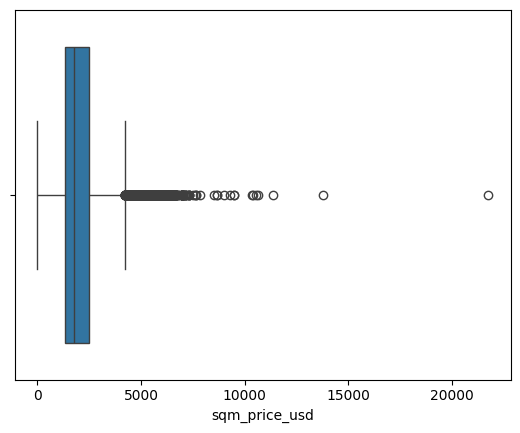

In [91]:
sns.boxplot(x='sqm_price_usd', data=data);

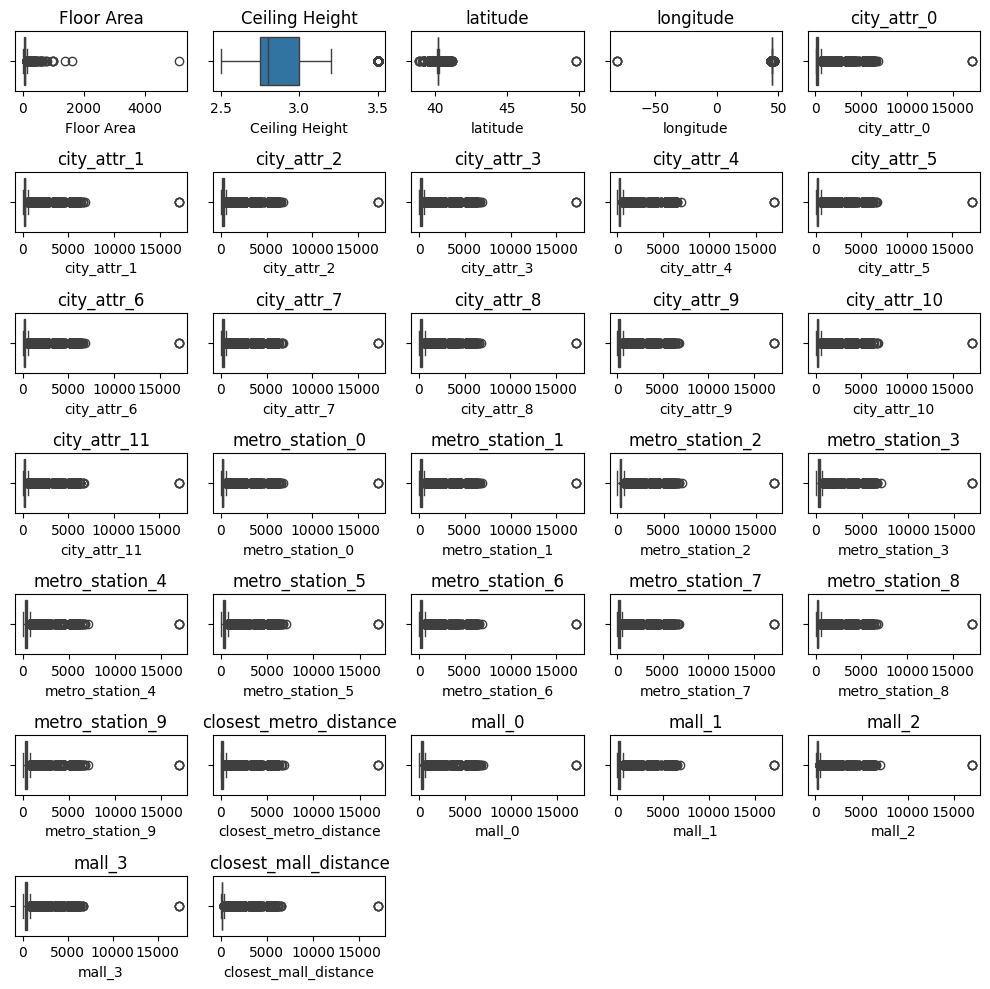

In [105]:
selected_ncols = 5

selected_nrows = int((len(num_feats_list) - len(num_feats_list) % selected_ncols) / selected_ncols)
if len(num_feats_list) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(10, 10))
for feat in num_feats_list:
    plt.subplot(selected_nrows, selected_ncols, num_feats_list.index(feat)+1)
    sns.boxplot(x=feat, data=data)
    plt.title(feat)
plt.tight_layout()

## Bivariate analysis

### Numeric features

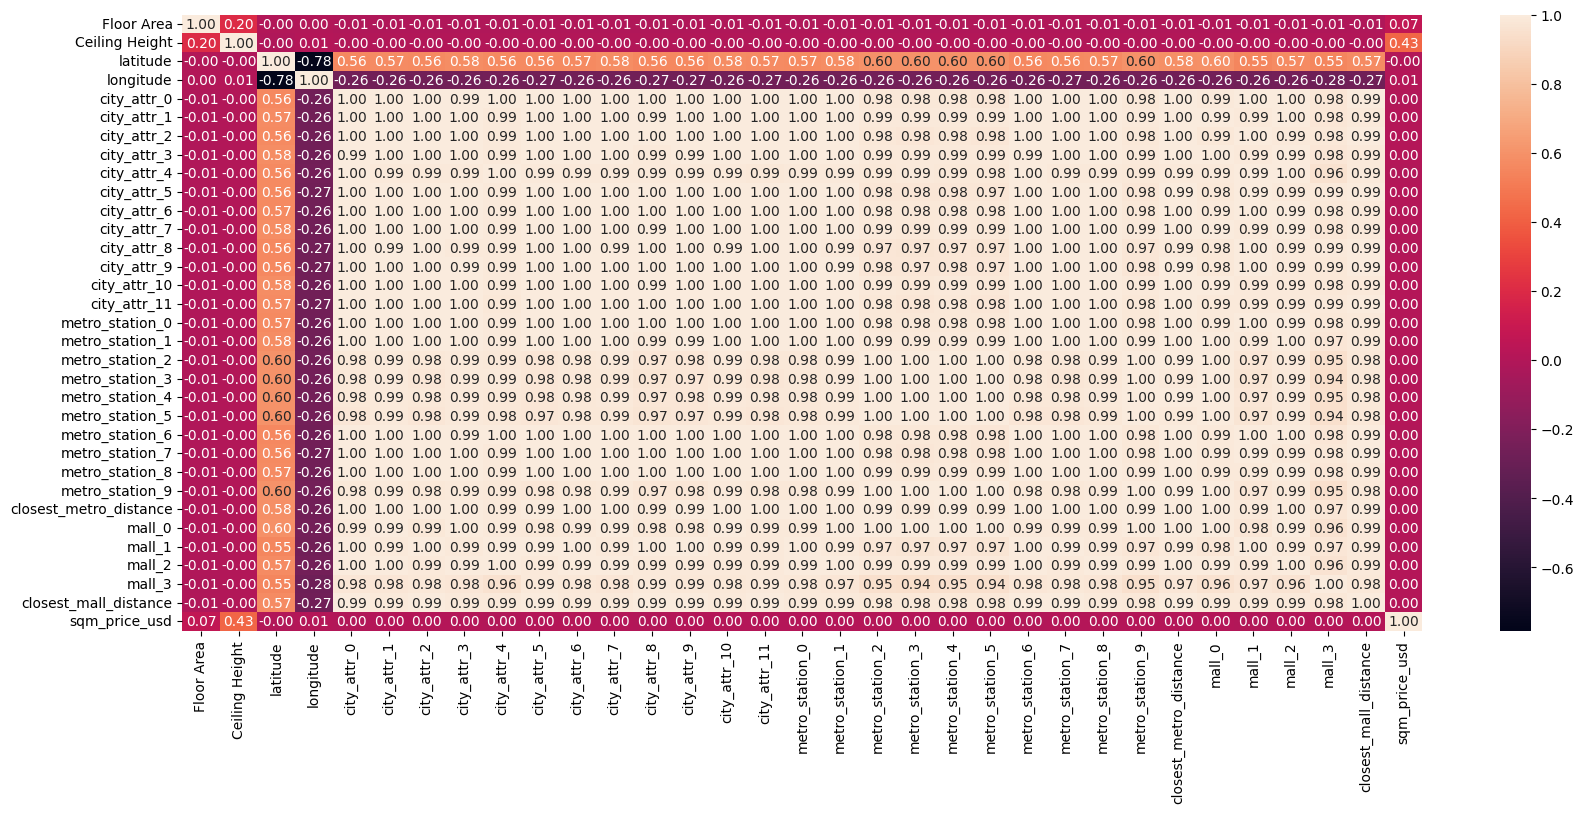

In [73]:
num_feats_list_with_target = num_feats_list.copy()
num_feats_list_with_target.append('sqm_price_usd')

corr_values = data[num_feats_list_with_target].corr()

fig = plt.figure(figsize=(20, 8))
sns.heatmap(corr_values, annot=True, fmt='.2f');

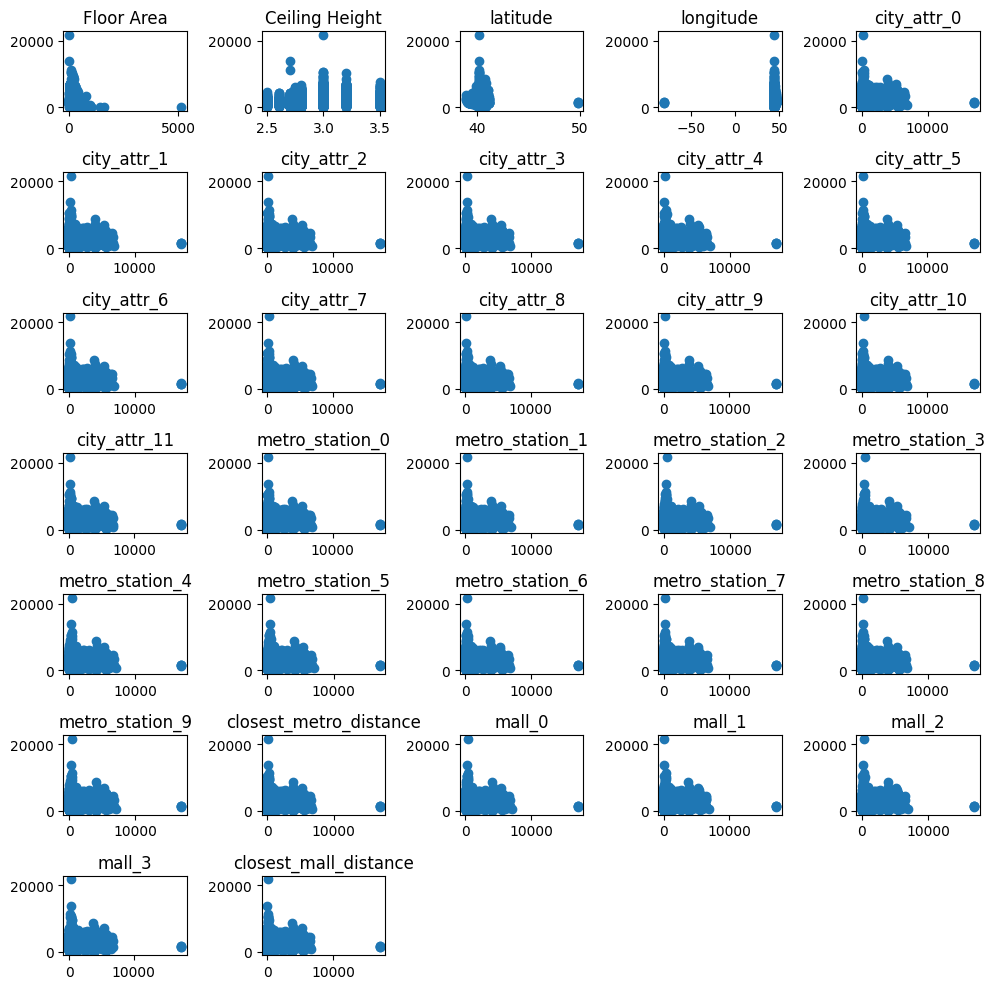

In [77]:
selected_ncols = 5

selected_nrows = int((len(num_feats_list) - len(num_feats_list) % selected_ncols) / selected_ncols)
if len(num_feats_list) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(10, 10))
for feat in num_feats_list:
    plt.subplot(selected_nrows, selected_ncols, num_feats_list.index(feat)+1)
    plt.scatter(data[feat], data['sqm_price_usd'])
    plt.title(feat)
plt.tight_layout()

In [84]:
data[(data['Floor Area'] > 500) & (data['sqm_price_usd']<500)][['address', 'sqm_price_usd', 'Floor Area']]

,address,sqm_price_usd,Floor Area
658,"Babajanyan St, Arinj",46.428571,1400
1727,"Улица Зоравара Андраника 23, Абовян",10.894942,5140
1748,"S.Avetisyan St 7, Spitak",40.000000,1000
3499,"Նոր Արեշի 12-րդ փողոց 41, Երևան",333.333333,750
5702,Yerevan › Erebuni,50.000000,1000
6012,"H. Abrahamyan street, Parakar",178.688525,610
7421,"Tamanyan street 23, Armavir",225.000000,800
7939,"Այվազովսկու փողոց 29, Արտաշատ",160.000000,1000
9350,"Noragavit 10-th Street 11, Yerevan",80.246914,1620
14256,Kotayk › Alapars,67.692308,650


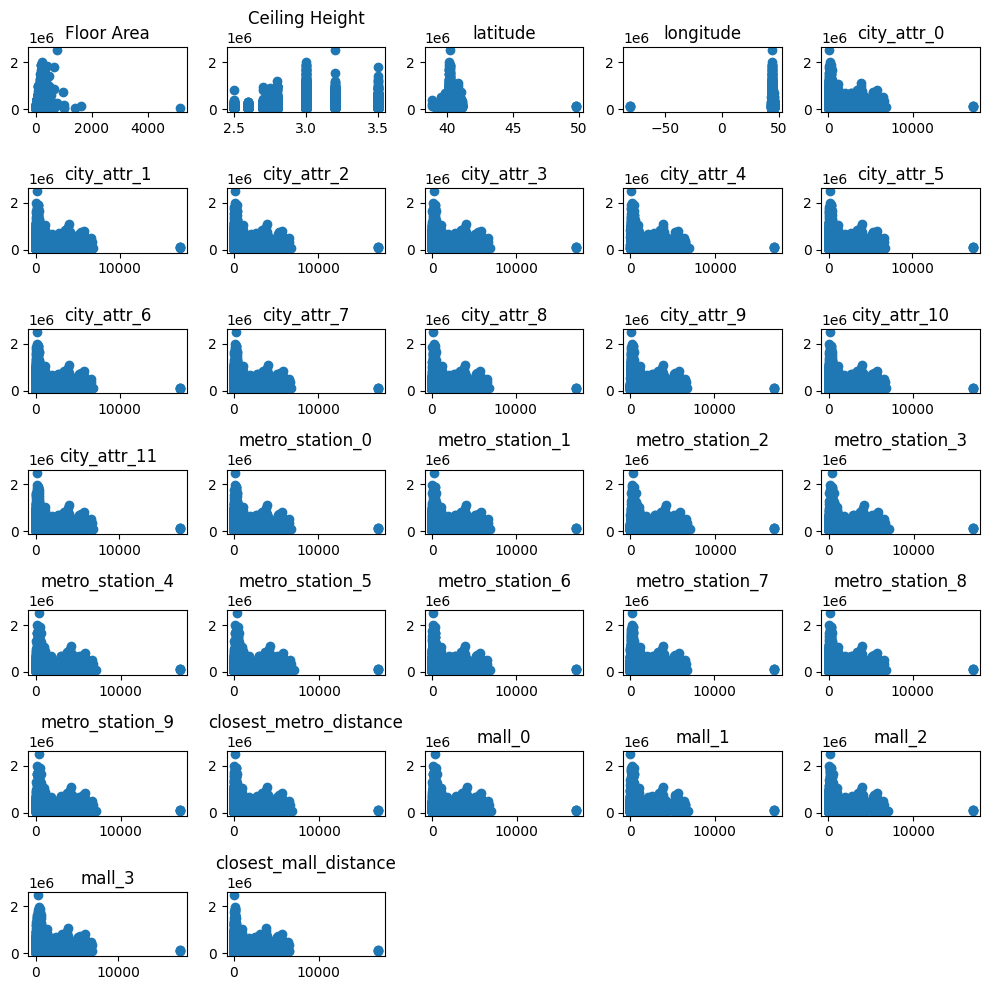

In [85]:
data['price'] = data['Floor Area'] * data['sqm_price_usd']

selected_ncols = 5

selected_nrows = int((len(num_feats_list) - len(num_feats_list) % selected_ncols) / selected_ncols)
if len(num_feats_list) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(10, 10))
for feat in num_feats_list:
    plt.subplot(selected_nrows, selected_ncols, num_feats_list.index(feat)+1)
    plt.scatter(data[feat], data['price'])
    plt.title(feat)
plt.tight_layout()

In [86]:
data[(data['Floor Area'] > 500) & (data['sqm_price_usd']<500)][['address', 'sqm_price_usd', 'Floor Area', 'price']]

,address,sqm_price_usd,Floor Area,price
658,"Babajanyan St, Arinj",46.428571,1400,65000.0
1727,"Улица Зоравара Андраника 23, Абовян",10.894942,5140,56000.0
1748,"S.Avetisyan St 7, Spitak",40.000000,1000,40000.0
3499,"Նոր Արեշի 12-րդ փողոց 41, Երևան",333.333333,750,250000.0
5702,Yerevan › Erebuni,50.000000,1000,50000.0
6012,"H. Abrahamyan street, Parakar",178.688525,610,109000.0
7421,"Tamanyan street 23, Armavir",225.000000,800,180000.0
7939,"Այվազովսկու փողոց 29, Արտաշատ",160.000000,1000,160000.0
9350,"Noragavit 10-th Street 11, Yerevan",80.246914,1620,130000.0
14256,Kotayk › Alapars,67.692308,650,44000.0


In [87]:
data['Floor Area'].value_counts()

Floor Area
80     875
78     558
75     532
90     532
65     527
      ... 
238      1
8        1
418      1
164      1
365      1
Name: count, Length: 290, dtype: int64

In [89]:
data.shape

(22133, 73)

In [88]:
data[data['Floor Area'] <= 300].shape

(22073, 73)

In [95]:
iqr = np.quantile(data['sqm_price_usd'], 0.75) - np.quantile(data['sqm_price_usd'], 0.25)

threshold_sqm_price_usd = np.quantile(data['sqm_price_usd'], 0.75) + 1.5 * iqr

threshold_sqm_price_usd

4218.75

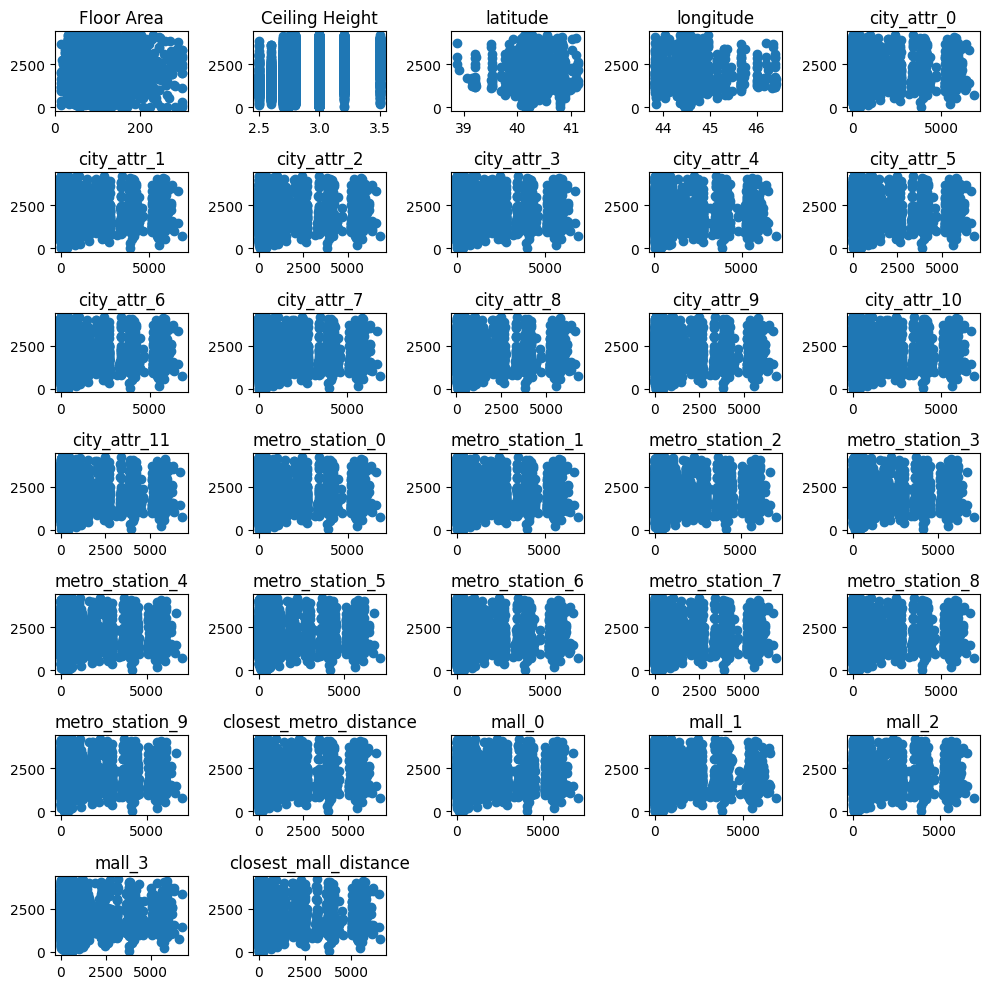

In [102]:
selected_ncols = 5

df = data[(data['Floor Area'] <= 300) & (data['sqm_price_usd']<= threshold_sqm_price_usd) & (data['city_attr_0']<10000)].copy()

selected_nrows = int((len(num_feats_list) - len(num_feats_list) % selected_ncols) / selected_ncols)
if len(num_feats_list) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(10, 10))
for feat in num_feats_list:
    plt.subplot(selected_nrows, selected_ncols, num_feats_list.index(feat)+1)
    plt.scatter(df[feat], df['sqm_price_usd'])
    plt.title(feat)
plt.tight_layout()

In [103]:
df.shape

(21184, 73)

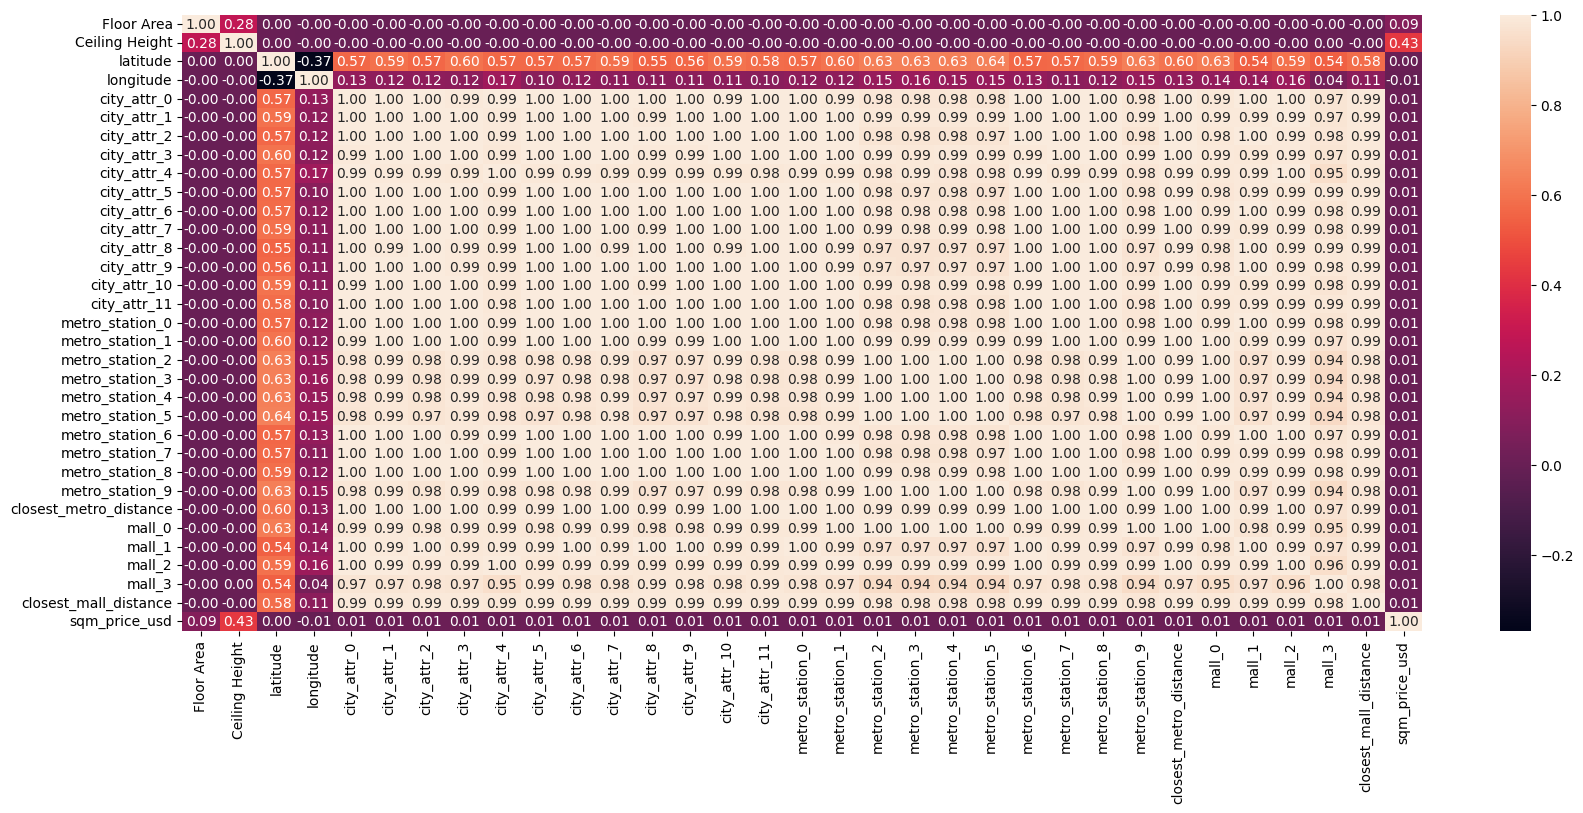

In [104]:
corr_values = df[num_feats_list_with_target].corr()

fig = plt.figure(figsize=(20, 8))
sns.heatmap(corr_values, annot=True, fmt='.2f');